In [1]:
!pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 67.2 MB/s eta 0:00:00


21:51:06 - cmdstanpy - INFO - Chain [1] start processing
21:51:06 - cmdstanpy - INFO - Chain [1] done processing


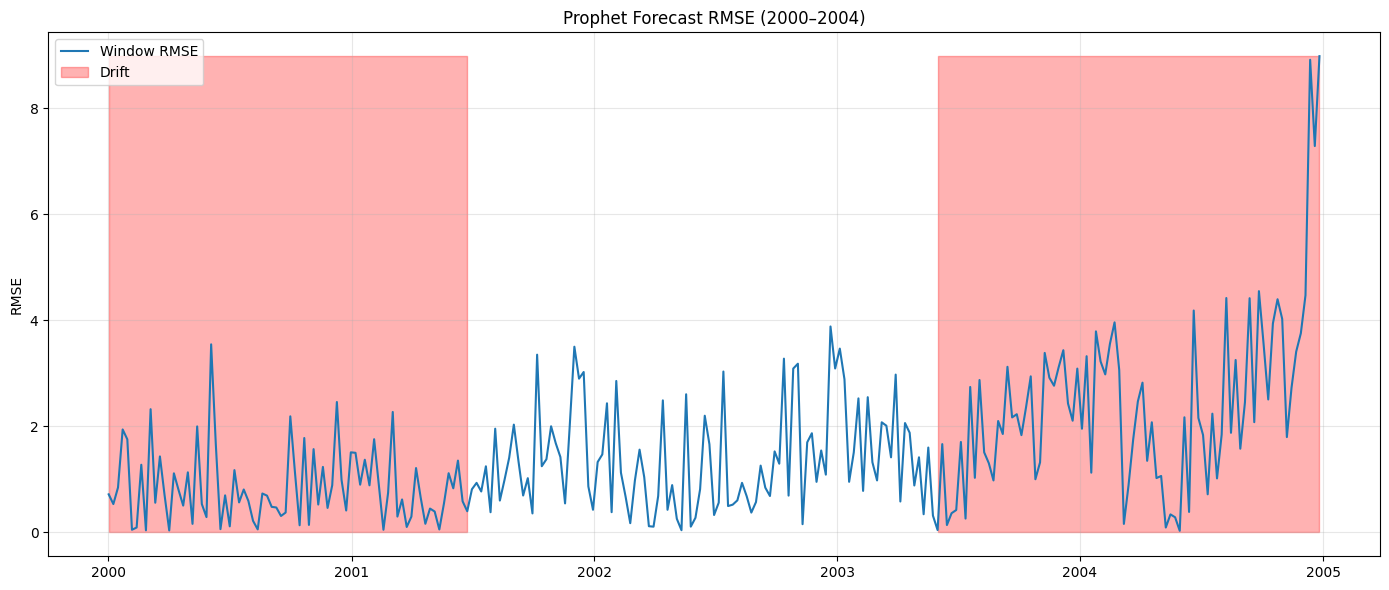

Stable RMSE: 1.681
Drift RMSE: 2.254
Robustness Ratio (Drift/Stable): 1.341


In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/SynData.csv', parse_dates=['date'])

df_prophet = df[['date', 'var1', 'drift_period']].rename(columns={'date': 'ds', 'var1': 'y'})

train_df = df_prophet[df_prophet['ds'] < '2000-01-01']
test_df = df_prophet[(df_prophet['ds'] >= '2000-01-01') & (df_prophet['ds'] <= '2004-12-31')]


model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
model.fit(train_df[['ds', 'y']])  

future = model.make_future_dataframe(periods=len(test_df), freq='W')
forecast = model.predict(future)

forecast_test = forecast[forecast['ds'].between('2000-01-01', '2004-12-31')].copy()
forecast_test['true_y'] = test_df['y'].values
forecast_test['drift_period'] = test_df['drift_period'].values
forecast_test['rmse'] = (forecast_test['yhat'] - forecast_test['true_y']) ** 2

drift_rmse = np.sqrt(forecast_test[forecast_test['drift_period'] == 1]['rmse'].mean())
stable_rmse = np.sqrt(forecast_test[forecast_test['drift_period'] == 0]['rmse'].mean())
robustness_ratio = drift_rmse / stable_rmse

plt.figure(figsize=(14, 6))
plt.plot(forecast_test['ds'], np.sqrt(forecast_test['rmse']), label='Window RMSE')
plt.fill_between(forecast_test['ds'], 0, np.sqrt(forecast_test['rmse']).max(),
                 where=forecast_test['drift_period'] == 1, alpha=0.3, color='red', label='Drift')
plt.title('Prophet Forecast RMSE (2000–2004)')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Stable RMSE: {stable_rmse:.3f}")
print(f"Drift RMSE: {drift_rmse:.3f}")
print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")


04:24:38 - cmdstanpy - INFO - Chain [1] start processing
04:24:38 - cmdstanpy - INFO - Chain [1] done processing



===== Test 1: Stable → Drift =====


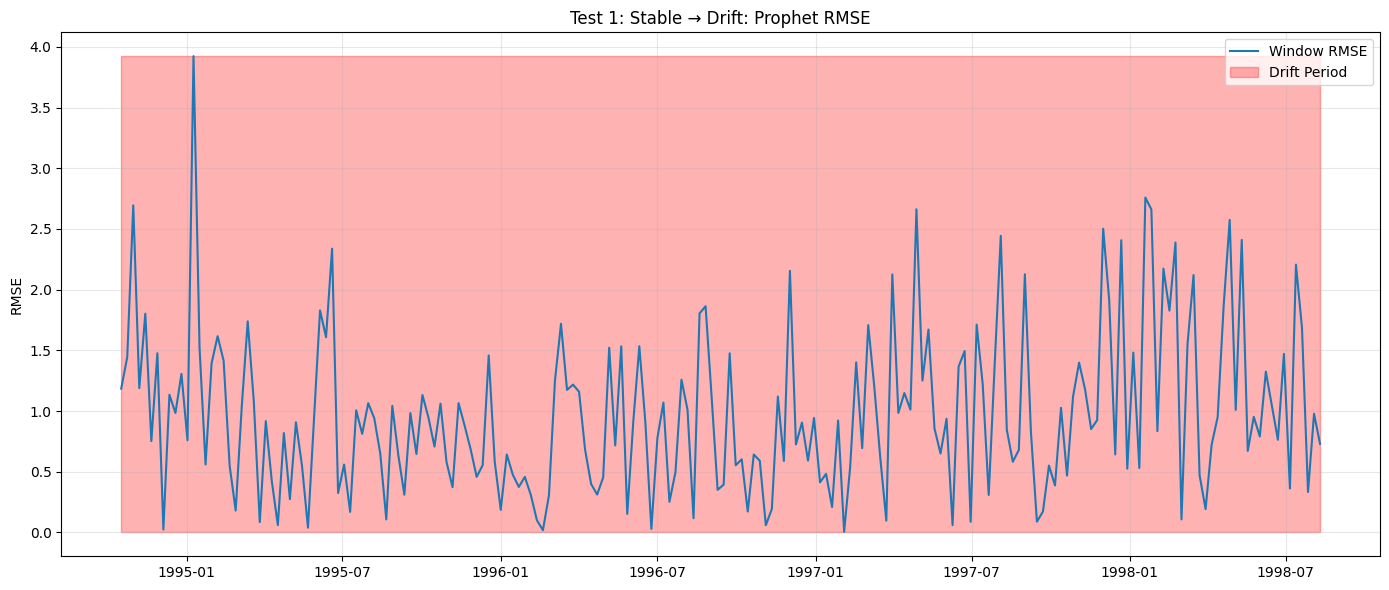

Stable RMSE: 0.919
Drift RMSE: 0.978
Robustness Ratio (Drift/Stable): 1.064


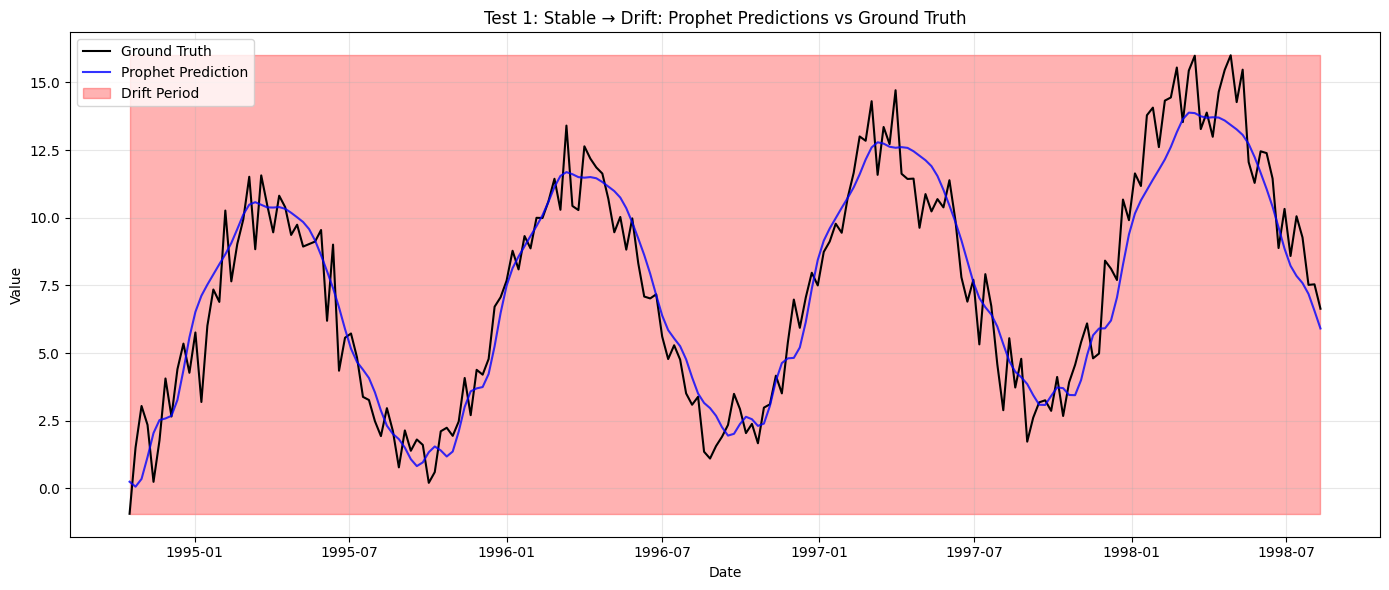

04:24:39 - cmdstanpy - INFO - Chain [1] start processing
04:24:39 - cmdstanpy - INFO - Chain [1] done processing



===== Test 2: Balanced Mix =====


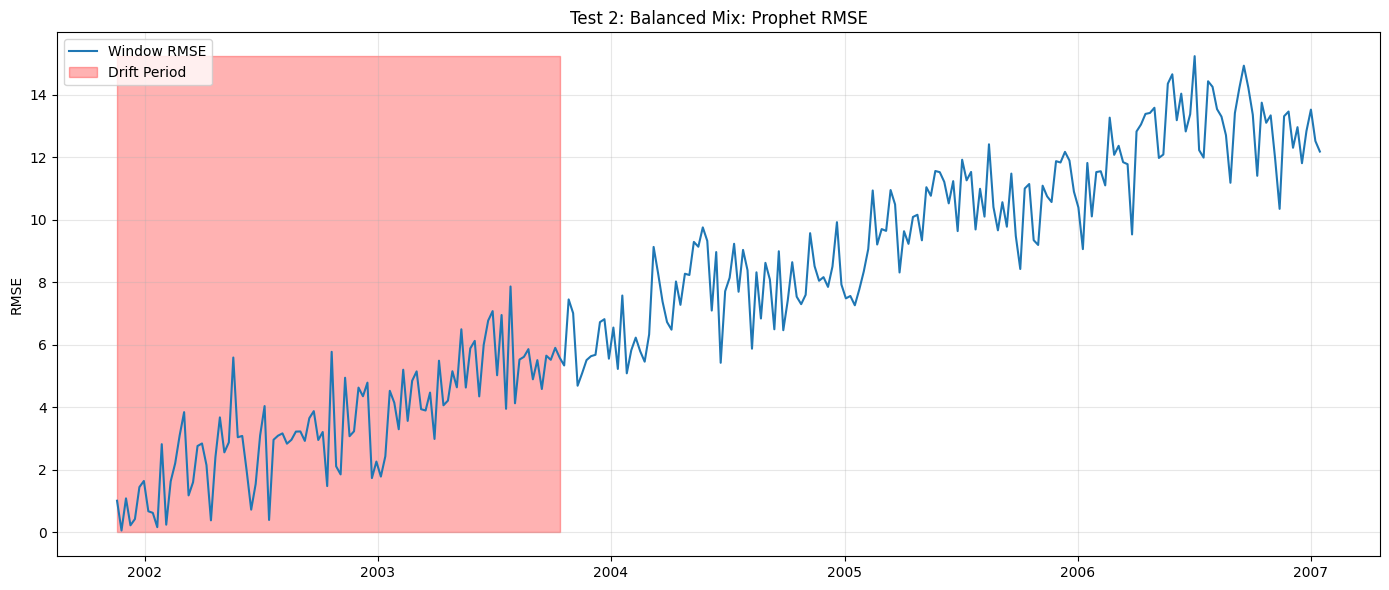

Stable RMSE: 9.965
Drift RMSE: 3.494
Robustness Ratio (Drift/Stable): 0.351


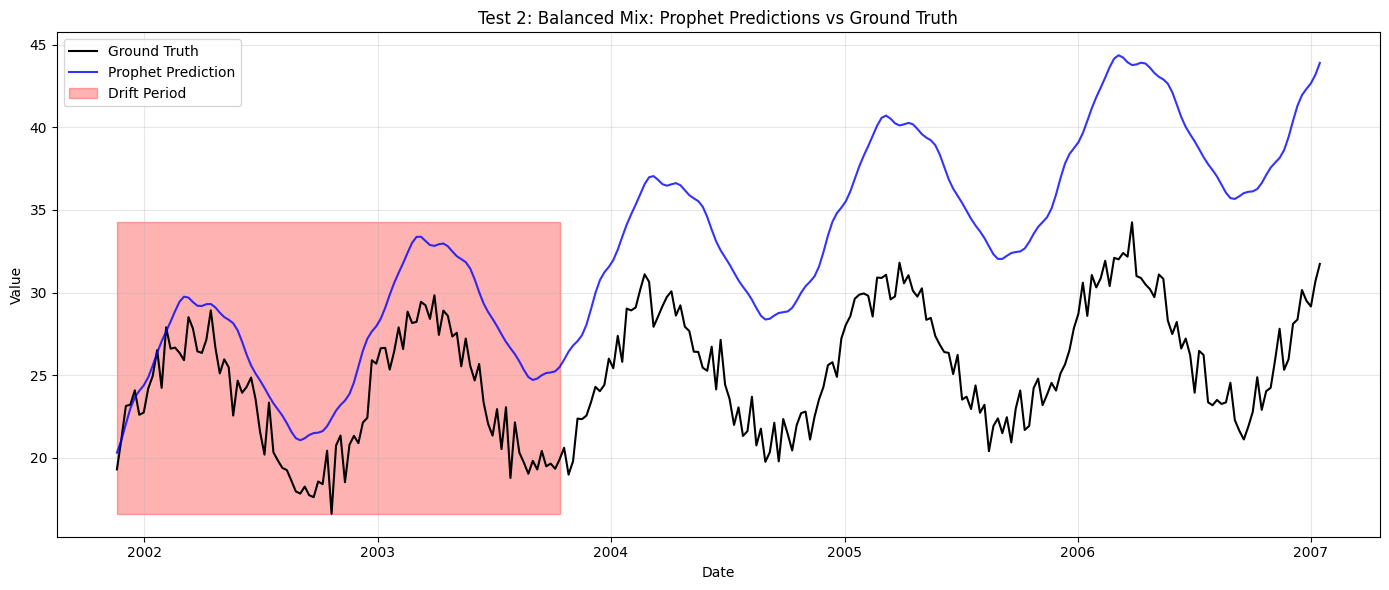

04:24:39 - cmdstanpy - INFO - Chain [1] start processing
04:24:39 - cmdstanpy - INFO - Chain [1] done processing



===== Test 3: Long Train, Short Inference =====


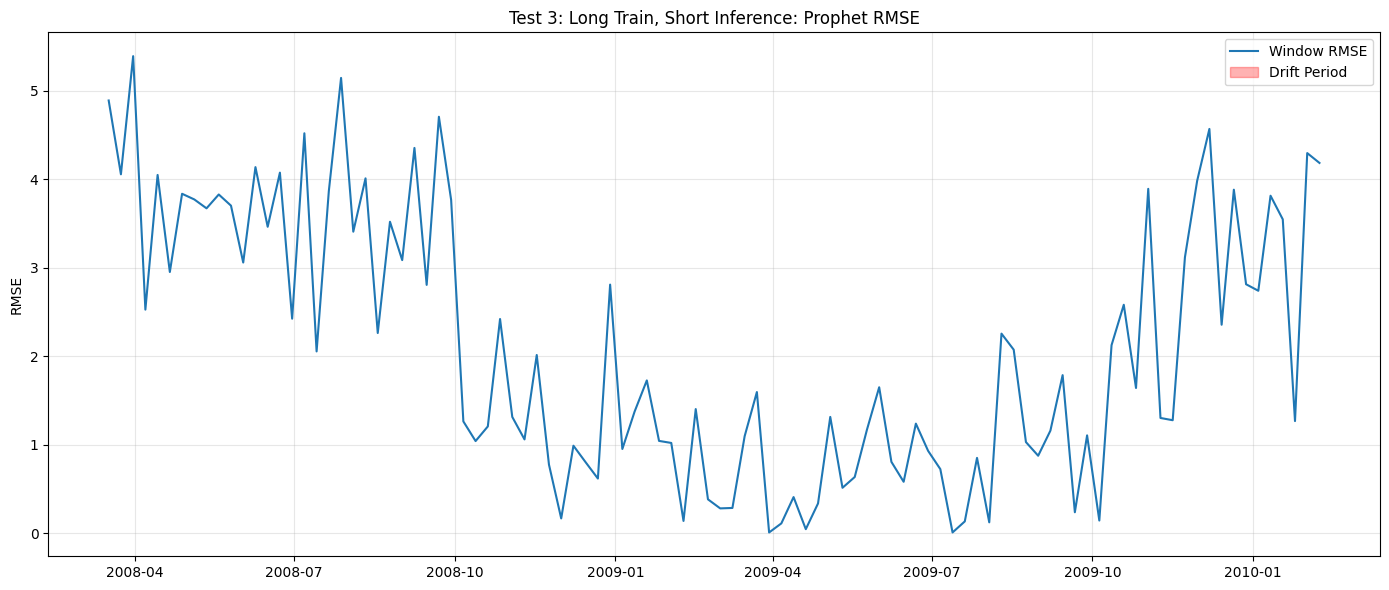

Stable RMSE: 2.108
Drift RMSE: 2.799
Robustness Ratio (Drift/Stable): 1.327


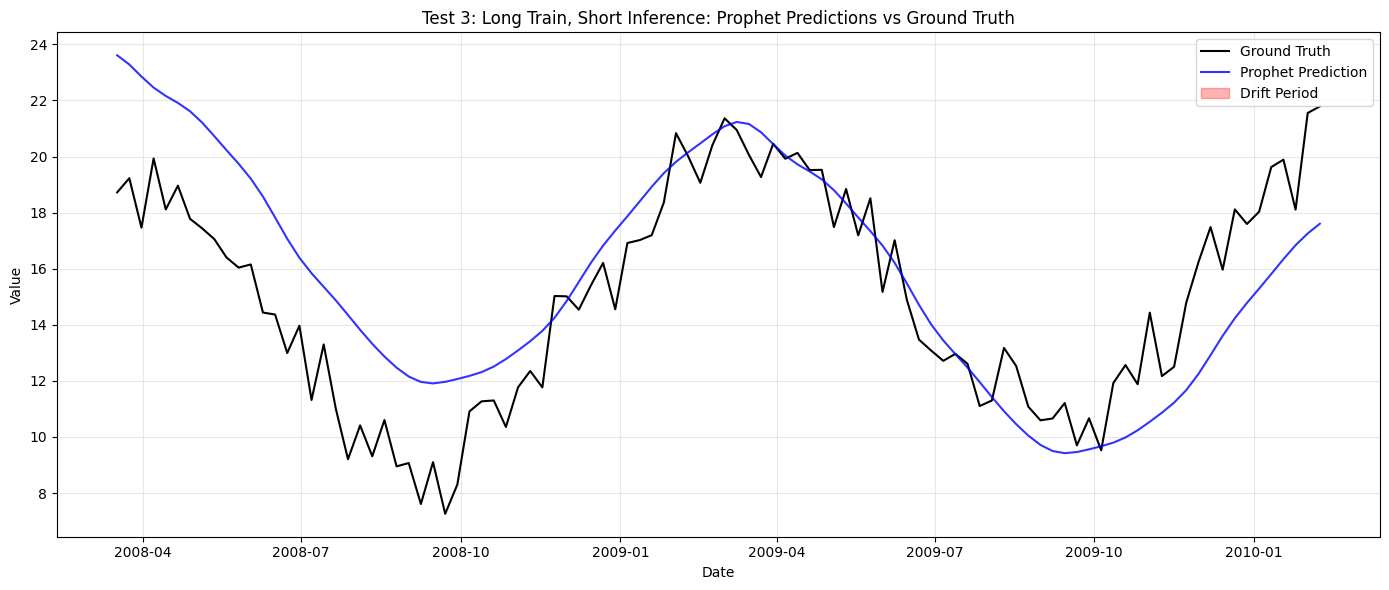

04:24:40 - cmdstanpy - INFO - Chain [1] start processing
04:24:40 - cmdstanpy - INFO - Chain [1] done processing



===== Test 4: Stable Only → Long Drift =====


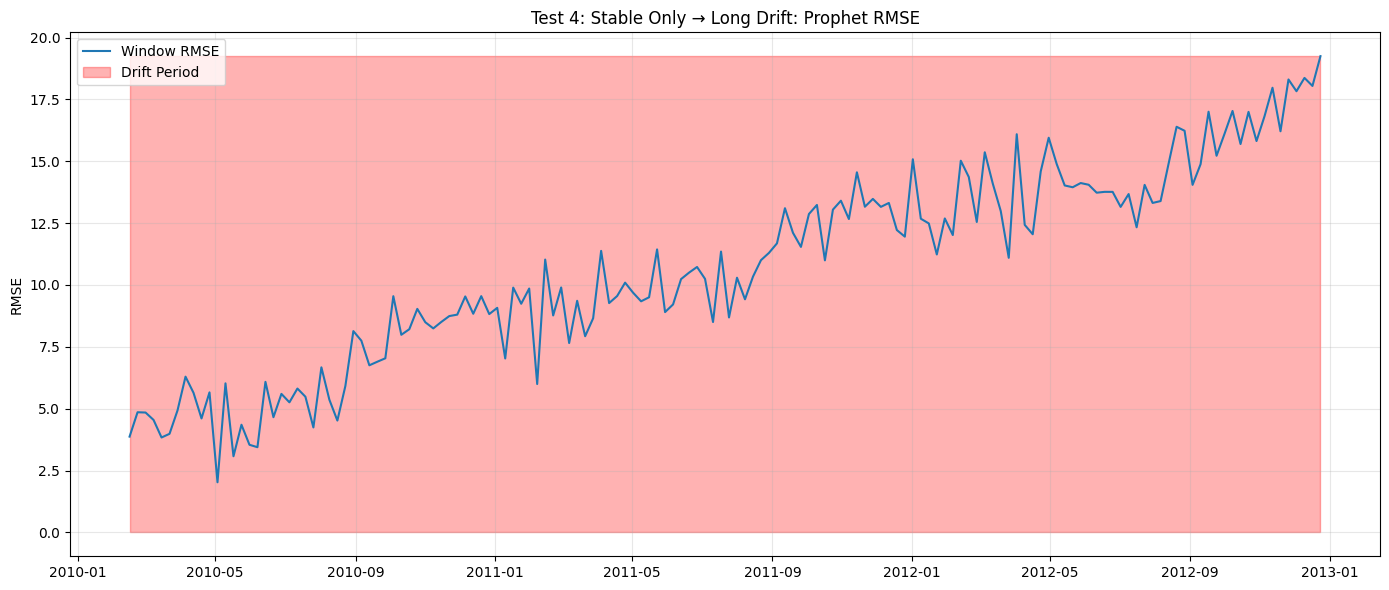

Stable RMSE: 1.917
Drift RMSE: 10.707
Robustness Ratio (Drift/Stable): 5.585


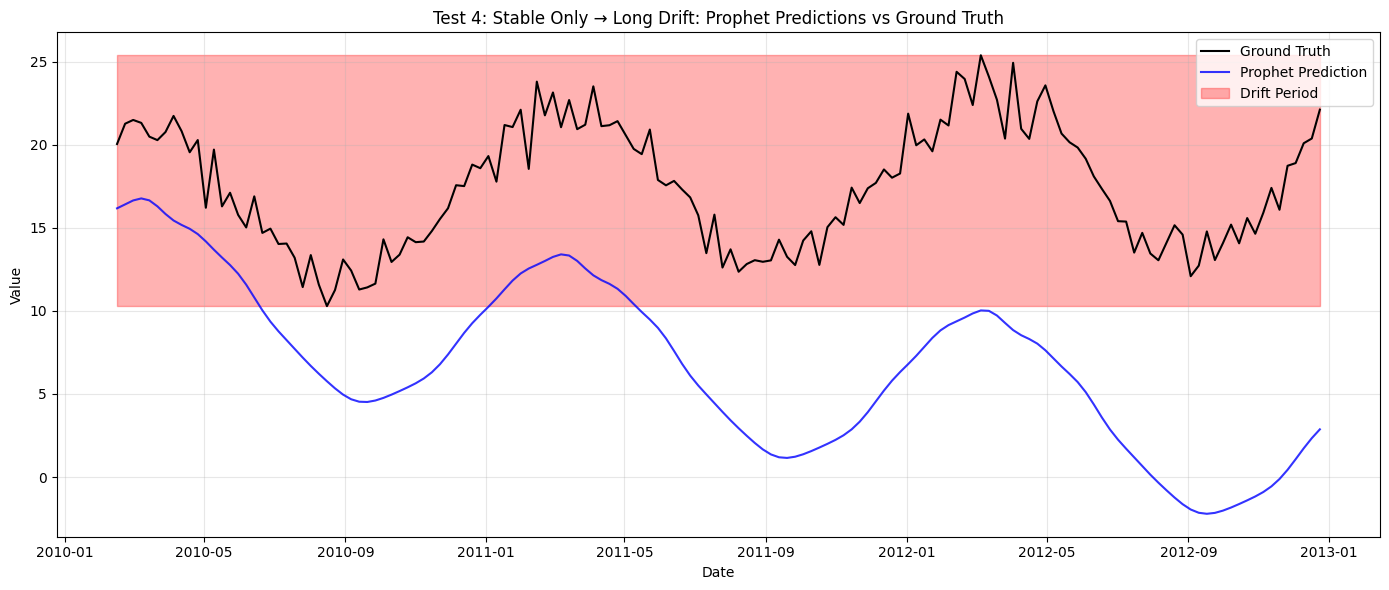

04:24:41 - cmdstanpy - INFO - Chain [1] start processing
04:24:41 - cmdstanpy - INFO - Chain [1] done processing



===== Test 5: Rolling Regimes =====


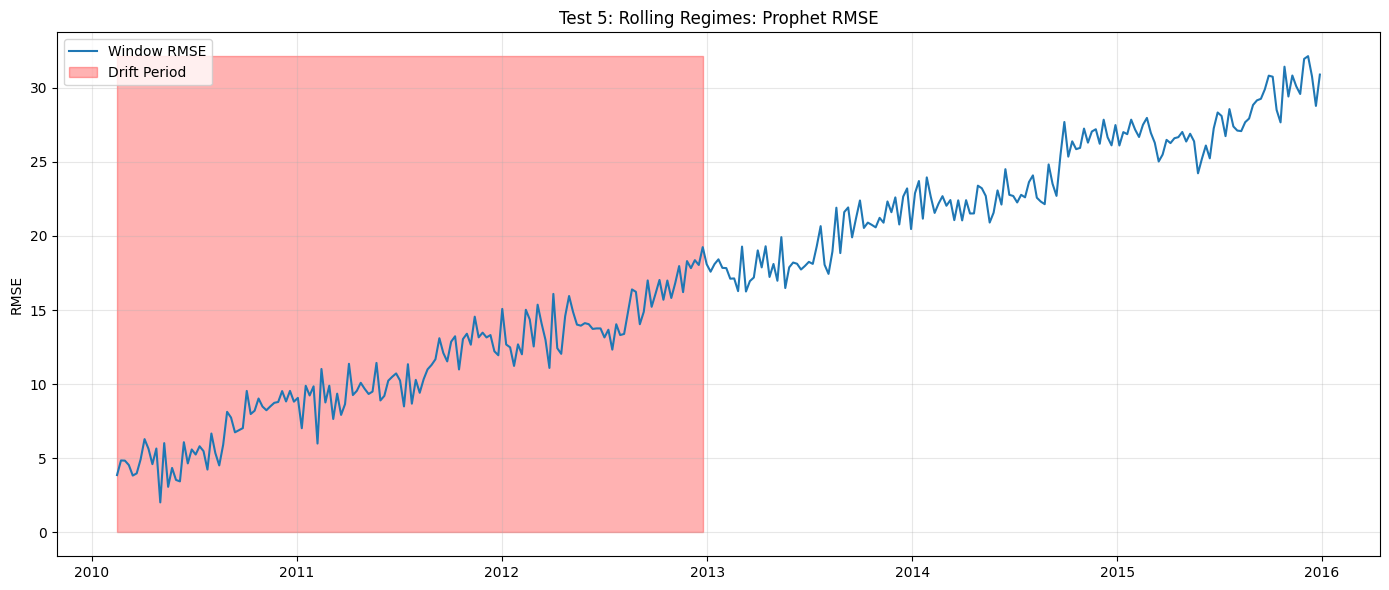

Stable RMSE: 23.603
Drift RMSE: 10.707
Robustness Ratio (Drift/Stable): 0.454


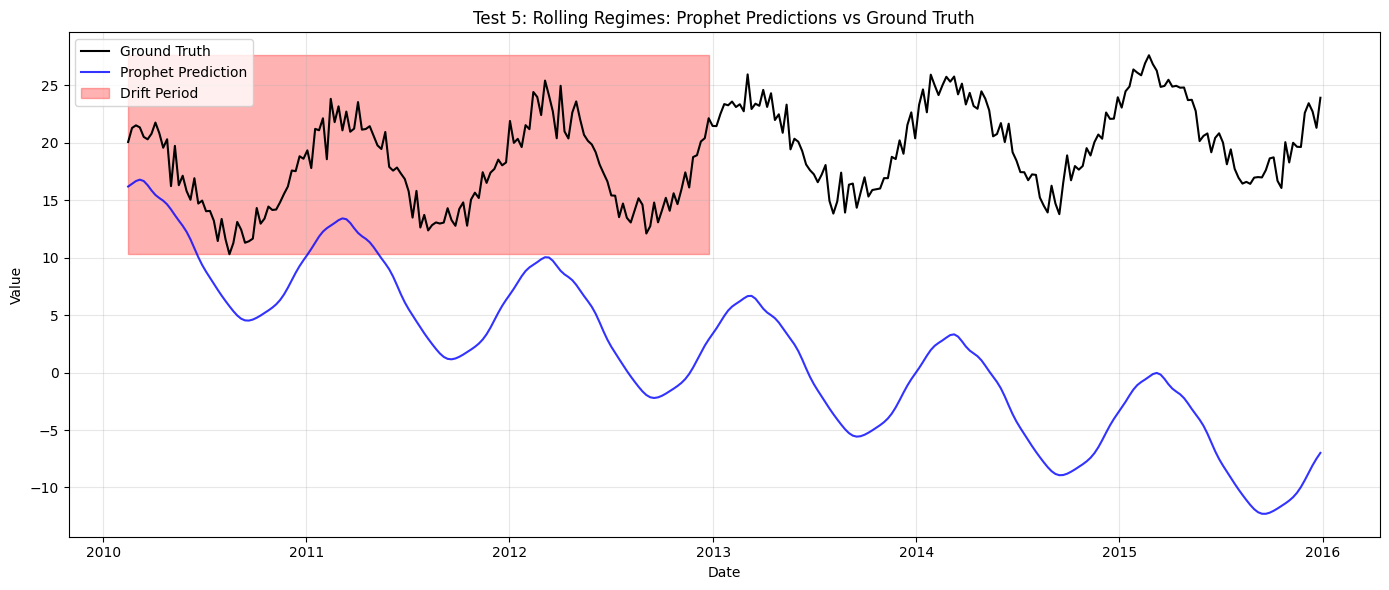

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error

df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)
df['ds'] = df.index
df['y'] = df['var1']

def run_prophet_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    train_df = df[(df['ds'] >= train_start) & (df['ds'] <= train_end)]
    infer_df = df[(df['ds'] >= infer_start) & (df['ds'] <= infer_end)]

    model = Prophet()
    model.fit(train_df[['ds', 'y']])

    future = infer_df[['ds']].copy()
    forecast = model.predict(future)

    merged = infer_df[['ds', 'y', 'drift_period']].merge(
        forecast[['ds', 'yhat']], on='ds', how='left'
    )
    merged['rmse'] = np.sqrt((merged['yhat'] - merged['y']) ** 2)

    plt.figure(figsize=(14, 6))
    plt.plot(merged['ds'], merged['rmse'], label='Window RMSE')
    plt.fill_between(merged['ds'], 0, merged['rmse'].max(),
                     where=merged['drift_period'] == 1, color='red', alpha=0.3, label='Drift Period')
    plt.title(f"{test_name}: Prophet RMSE")
    plt.ylabel("RMSE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    stable_rmse = merged[merged['drift_period'] == 0]['rmse'].mean()
    drift_rmse = merged[merged['drift_period'] == 1]['rmse'].mean()

    if np.isnan(stable_rmse):
        stable_sample = train_df[train_df['drift_period'] == 0].copy()
        if len(stable_sample) >= 12:
            future_stable = stable_sample[['ds']]
            pred_stable = model.predict(future_stable)
            stable_rmse = np.sqrt(mean_squared_error(stable_sample['y'], pred_stable['yhat']))

    if np.isnan(drift_rmse):
        drift_sample = train_df[train_df['drift_period'] == 1].copy()
        if len(drift_sample) >= 12:
            future_drift = drift_sample[['ds']]
            pred_drift = model.predict(future_drift)
            drift_rmse = np.sqrt(mean_squared_error(drift_sample['y'], pred_drift['yhat']))

    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")
    
        # === Ground Truth vs Forecast Plot ===
    plt.figure(figsize=(14, 6))
    plt.plot(merged['ds'], merged['y'], label='Ground Truth', color='black', linewidth=1.5)
    plt.plot(merged['ds'], merged['yhat'], label='Prophet Prediction', color='blue', alpha=0.8)
    plt.fill_between(merged['ds'],
                     merged['y'].min(), merged['y'].max(),
                     where=merged['drift_period'] == 1,
                     color='red', alpha=0.3, label='Drift Period')
    plt.title(f"{test_name}: Prophet Predictions vs Ground Truth")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


run_prophet_test("Test 1: Stable → Drift",
         "1990-01-01", "1994-10-10",
         "1994-10-17", "1998-08-10")

run_prophet_test("Test 2: Balanced Mix",
         "1994-10-17", "2001-11-12",
         "2001-11-19", "2007-01-15")

run_prophet_test("Test 3: Long Train, Short Inference",
         "1990-01-01", "2008-03-10",
         "2008-03-17", "2010-02-08")

run_prophet_test("Test 4: Stable Only → Long Drift",
         "1990-01-01", "2010-02-08",
         "2010-02-15", "2012-12-24")

run_prophet_test("Test 5: Rolling Regimes",
         "1990-01-01", "2010-02-08",
         "2010-02-15", "2015-12-28")
